In [150]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [151]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

#프로젝트를 진핼할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 30

print(ROOT_PATH)

/aiffel/aiffel


## 1. 데이터 가져오기
---

In [152]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames)) # 89%
print(len(test_filenames)) # 10.7%
print(len(val_filenames)) # 0.3%

5216
624
16


# 2. 데이터 전처리 및 데이터 셋 설정
---

In [153]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames 를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [154]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0582-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person313_bacteria_1457.jpeg


In [155]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [156]:
# tf.data 인스턴스를 만들어 봅시다. 
# tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [157]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f'Training images count: {TRAIN_IMG_COUNT}')

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f'Validating images count: {VAL_IMG_COUNT}')

Training images count: 4185
Validating images count: 1047


In [158]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA" # 페렴이면 양성(True), 노말이면 음성(False)

In [159]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 Image_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [160]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [161]:
for image, label in train_ds.take(1): # 하나의 데이터만 가져온다는 뜻!
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [162]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [163]:
def augment(image, label): # 데이터양 증가
    image = tf.image.random_flip_left_right(image) # 랜덤하게 좌우를 반전합니다.
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치 처리 함수에 추가 되었습니다.
    ds = ds.map(
        augment, # augment 함수 적용
        num_parallel_calls=2
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
    ds = ds.repeat() # epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
    ds = ds.batch(BATCH_SIZE) #  BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.
    
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화
---

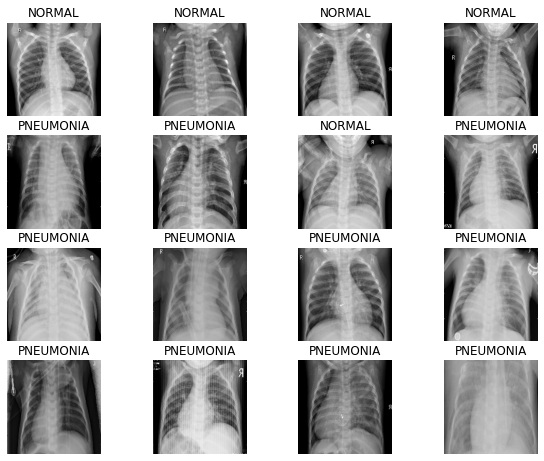

In [164]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5, math.ceil(BATCH_SIZE/5), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. 모델 설계
---

In [165]:
# CONV BLOCK
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [166]:
# DENSE BLOCK
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [167]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. 데이터 imbalance 처리
---

In [168]:
weight_for_0 = (1/COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1/COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('weight for NORMAL: {:.2f}'.format(weight_for_0))
print('weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

weight for NORMAL: 1.96
weight for PNEUMONIA: 0.67


# 6. 모델 훈련
---

In [186]:
from keras.callbacks import EarlyStopping

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/30
261/261 [==============================] - 42s 133ms/step - loss: 0.5856 - accuracy: 0.7016 - precision: 0.8990 - recall: 0.6712 - val_loss: 0.7209 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 34s 129ms/step - loss: 0.2493 - accuracy: 0.8936 - precision: 0.9749 - recall: 0.8802 - val_loss: 1.3201 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 34s 129ms/step - loss: 0.2314 - accuracy: 0.9167 - precision: 0.9716 - recall: 0.9153 - val_loss: 0.1306 - val_accuracy: 0.9500 - val_precision: 0.9451 - val_recall: 0.9895
Epoch 4/30
261/261 [==============================] - 34s 130ms/step - loss: 0.1821 - accuracy: 0.9242 - precision: 0.9807 - recall: 0.9170 - val_loss: 0.1677 - val_accuracy: 0.9279 - val_precision: 0.9105 - val_recall: 1.0000
Epoch 5/30
261/261 [==============================] - 34s 129ms/step - loss: 0.1742 - accura

# 7. 모델의 형태

In [191]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_24 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_25 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_26 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_15 (Dropout)         (None, 11, 11, 128)     

# 8. 학습 결과 확인(시각화)
---

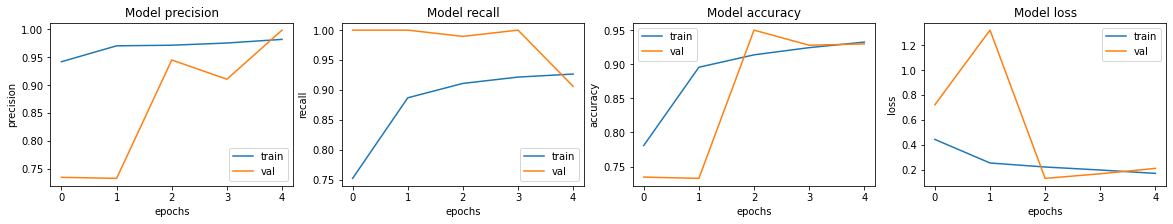

In [187]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 9. 테스트 (acc:86%)

In [188]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 0.3781 - accuracy: 0.8606 - precision: 0.8515 - recall: 0.9410
Loss: 0.37814050912857056,
Accuracy: 0.8605769276618958,
Precision: 0.8515081405639648,
Recall: 0.9410256147384644


In [193]:
print(f'Accuracy : {accuracy*100}')

Accuracy : 86.05769276618958


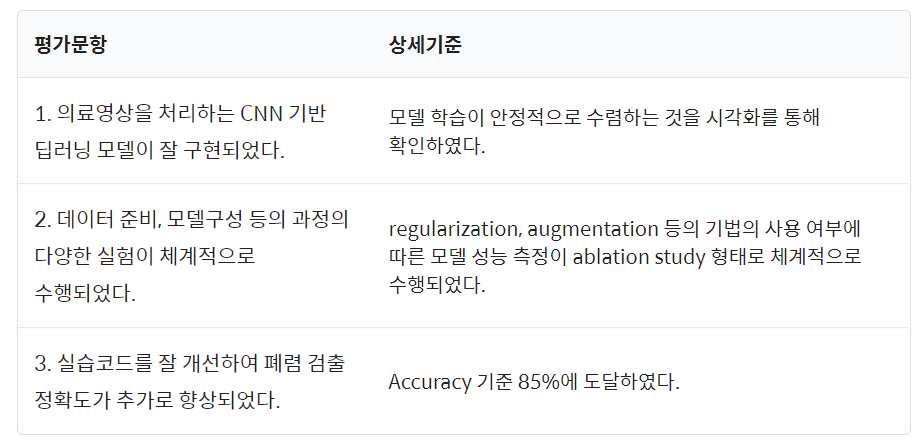

# 10. 회고
---

## - 이번 프로젝트에서 **어려웠던 점,**
    - Augment 하여도 데이터의 양이 적다보니 Accuracy가 학습할때마다 일정하지 않고 흔들려서 여러번 학습을 재시도 하였다.
    - EarlyStopping 모듈을 사용하기 전 이미지다보니 학습시간이 오래걸려서 어려웠다.
    - 기존 Local 에서 학습을 진행하는데 LMS 클라우드 보다 10배 이상 시간이 걸려서 확인해보니 CPU만 사용하고 있었다... 그래서 GPU를 사용할 수 있도록 세팅하고, 테스트하는데 시간이 오래 걸렸다.(성공했지만 그래도 클라우드 보다 2배 정도의 시간이 더 걸려 LMS 클라우드에서 해당 노드를 진행하였다...GPU 사양 문제라고 생각한다.)
    
    
## - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
    - Accuracy가 일정하지 않고 매 학습마다 흔들리는게 실제 데이터의 양 때문만이 문제인지 아직 모호하다.
    
    
## - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
    - 모델 학습을 여러번 시도하였다.
    - 노드에서 제시한 방법인 BatchNormalization과 Dropout에 대하여 사용하지 않거나 사용하거나 하여 경우의 수를 모두 테스트 해본 결과 해당 모델 같은 경우 둘 다 사용하는 것이 Accuracy가 가장 잘 나와 두 개 모두 사용하였다.
    - 노드에서 기존 30회를 제시하였었는데 과적합현상이 발생하여 EarlyStopping 모듈을 사용하여 과적합을 방지하였다.
    
    
## - **자기 다짐**
    - 모델 구동이 어떻게 되는지 최대한 파악하도록 노력하여, Accuracy를 높일 수 있는 방법을 시도해보자.